*If you run this notebook at colab.research.google.com, you need to install packages with the following command*:

In [1]:
# !pip install -r https://raw.githubusercontent.com/obidam/ds2-2022/main/requirements.txt
# !curl https://raw.githubusercontent.com/obidam/ds2-2022/main/practice/exploratory_statitics/tuto_tools.py --output tuto_tools.py

# Profile Classification Model
## Standard Classification workflow demonstration

We're going to classify Argo data with the following workflow:
 - Load netcdf Argo profiles on Standard Depth Levels
 - Normalize profiles
 - Compress the collection with PCA (dimensionality reduction)
 - Train a GMM on the reduced dataset
 - Classify all the dataset
 - Compute class profile statistics
 - Create a map with labels by profiles

Along the way, we'll produce figures to be compared with Maze et al, POC, 2017

@author: gmaze@ifremer.fr

More documentations:
- http://scikit-learn.org
- http://xarray.pydata.org
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- http://scikit-learn.org/stable/modules/mixture.html

## Import modules and libraries

In [2]:
import os
import numpy as np
import xarray, dask
import matplotlib.pyplot as plt
import matplotlib as mpl
# from mpl_toolkits.basemap import Basemap as bm
# import pandas as pd

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture

import seaborn as sns
from intake import open_catalog

from tuto_tools import vrange, vrangec, plot_GMMellipse, sns_GMMellipse, create_map

## Define key parameters of the analysis

In [3]:
# Number of GMM classes to compute:
K = 8

# Compression level for the dimensionality reduction 
maxvar = 99.9 # in %

## Load data and create a X[Np,Nz] array to work with

From Google cloud storage [see specific tuto here](https://github.com/obidam/ds2-2022/blob/main/practice/environment/02-Access_to_data_in_the_cloud.ipynb).

Use in-situ measurements from Argo floats, interpolated on standard depth levels

In [4]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2020/ds2-2021/ds2_data_catalog.yml'
ds = open_catalog(catalog_url)['argo_global_homogeneous_sdl'].read_chunked()

# Squeeze data to the North Atlantic domain:
ds = ds.where(ds['LATITUDE']>0, drop=True)
ds = ds.where(ds['LONGITUDE']>=-80, drop=True)
ds = ds.where(ds['LONGITUDE']<=0, drop=True)

#
print('This dataset holds: %.3f MB' % (ds.nbytes / 1e6))
print(ds)

/Users/gmaze/anaconda/envs/ds2/lib/python3.8/site-packages/intake_xarray/xzarr.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  self._ds = xr.open_zarr(self._mapper, **self.kwargs)


This dataset holds: 67.742 MB
<xarray.Dataset>
Dimensions:    (N_PROF: 13950, DEPTH: 302)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 ... -1.495e+03 -1.5e+03 -1.505e+03
    LATITUDE   (N_PROF) float32 dask.array<chunksize=(7170,), meta=np.ndarray>
    LONGITUDE  (N_PROF) float32 dask.array<chunksize=(7170,), meta=np.ndarray>
    TIME       (N_PROF) datetime64[ns] dask.array<chunksize=(7170,), meta=np.ndarray>
Dimensions without coordinates: N_PROF
Data variables:
    BRV2       (N_PROF, DEPTH) float32 dask.array<chunksize=(7170, 302), meta=np.ndarray>
    DBINDEX    (N_PROF) float64 dask.array<chunksize=(7170,), meta=np.ndarray>
    PSAL       (N_PROF, DEPTH) float32 dask.array<chunksize=(7170, 302), meta=np.ndarray>
    SIG0       (N_PROF, DEPTH) float32 dask.array<chunksize=(7170, 302), meta=np.ndarray>
    TEMP       (N_PROF, DEPTH) float32 dask.array<chunksize=(7170, 302), meta=np.ndarray>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       CF-1.6
 

In [5]:
# Select the depth layer for training:
#dsub = ds.sel(DEPTH=slice(-100,-1000))
dsub = ds.sel(DEPTH=slice(0,-1400))

# And Create the array X(Nz,Np): The field to classify with a GMM, 
# Np profiles with Nz depth levels.
X = dsub['TEMP'].values
DPTmodel = dsub['DEPTH'].values
lon = dsub['LONGITUDE'].values
lat = dsub['LATITUDE'].values
          
# Size of the training set X:
[Np, Nz] = X.shape
print("Number of raw features (Depth Levels): ", Nz)
print("Number of samples (N profiles): ", Np)

Number of raw features (Depth Levels):  281
Number of samples (N profiles):  13950


## Normalization
We operate along feature dimensions to:
- Remove the sample mean
- Divide by the sample std

one depth level at a time

Create the Xn[Np,Nz] array

Doc:
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [6]:
# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_

# Normalize data:
Xn = scaler.transform(X)       

# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(X).transform(X)

# Compute additional statistics, like the observed PDFz:
def diag_pdfz(X,xedges):
    Nz = X.shape[1]
    PDFz = np.zeros((xedges.shape[0]-1,Nz))
    for iz in np.arange(Nz):
        h, hx = np.histogram(X[:,iz],bins=xedges,density=True)
        PDFz[:,iz] = h
    PDFz_axis = hx[0:-1]
    return PDFz, PDFz_axis
PDFz, PDFz_axis = diag_pdfz(X,np.arange(0,30,0.2))

### Figure

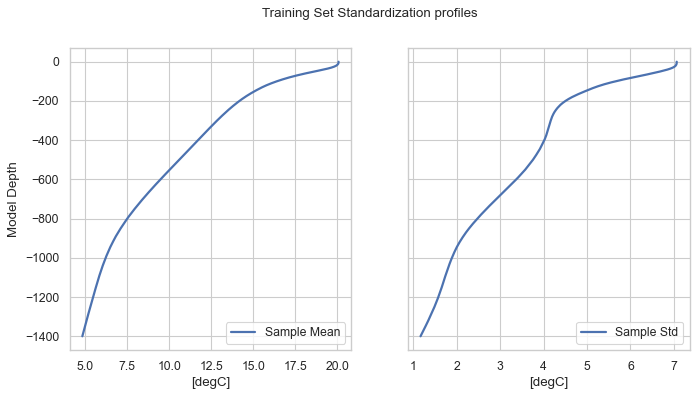

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X_ave, DPTmodel, '-', linewidth=2,label='Sample Mean')
ax[1].plot(X_std, DPTmodel, '-', linewidth=2,label='Sample Std')
# tidy up the figure
ax[0].set_ylabel('Model Depth')
for ix in range(0,2):
    ax[ix].legend(loc='lower right')
    ax[ix].grid(True)
    ax[ix].set_xlabel('[degC]')
fig.suptitle('Training Set Standardization profiles', fontsize=12)
plt.show()

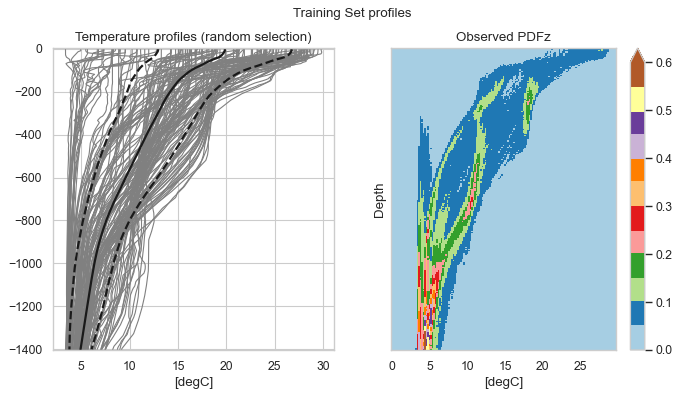

In [8]:
# Select 100 random profiles:
n = 150
ip = np.unique(np.random.randint(0,Np-1,n))

# Random selection of profiles
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X[ip,:].T, np.reshape(np.repeat(DPTmodel,ip.shape[0]),[Nz,ip.shape[0]]), '-', color='gray', linewidth=1)
ax[0].plot(np.mean(X[ip,:].T,axis=1), DPTmodel, '-', color='k', linewidth=2)
ax[0].plot(np.mean(X[ip,:].T,axis=1)-np.std(X[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].plot(np.mean(X[ip,:].T,axis=1)+np.std(X[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].grid(True)
ax[0].set_title('Temperature profiles (random selection)')
ax[0].set_xlabel('[degC]')

cmap = plt.get_cmap('Paired',lut=128)
df = xarray.DataArray(PDFz.T, coords=[DPTmodel,PDFz_axis], dims=['Depth','[degC]'])
p = df.plot(cmap=cmap,vmin=0,vmax=0.6,ax=ax[1])
ax[1].set_title("Observed PDFz")

fig.suptitle('Training Set profiles', fontsize=12)
plt.show()

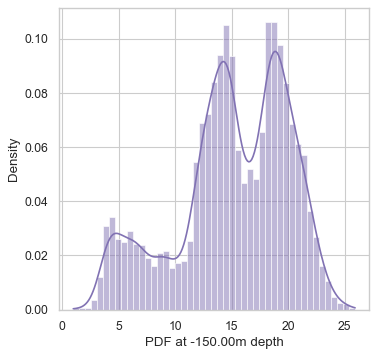

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook",style="whitegrid", palette="deep", color_codes=True)
iz = 30
sns.histplot(X[:,iz], color="m", kde=True, ax=ax, stat='density')
ax.set_xlabel("PDF at %0.2fm depth"%(DPTmodel[iz]));

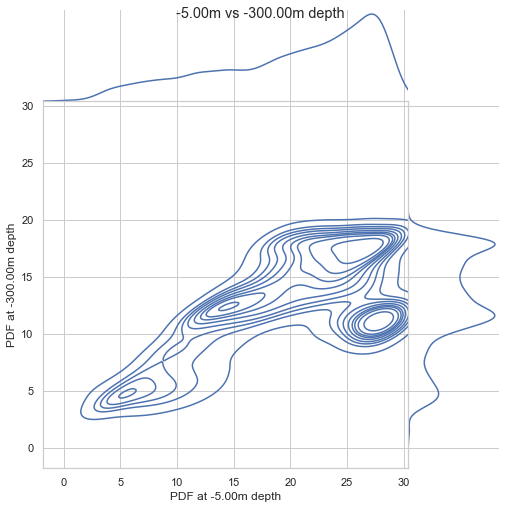

In [10]:
iz1 = 1
iz2 = np.argmax(DPTmodel<=-300)
x = X[:,iz1]
y = X[:,iz2]
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook", style="whitegrid", color_codes=True)
sns.jointplot(x=x, y=y, kind="kde",\
              xlim=vrange([x,y]),ylim=vrange([x,y]),\
              height=7, ratio=4, space=0)\
            .set_axis_labels("PDF at %0.2fm depth"%(DPTmodel[iz1]), "PDF at %0.2fm depth"%(DPTmodel[iz2]))
plt.suptitle("%0.2fm vs %0.2fm depth"%(DPTmodel[iz1],DPTmodel[iz2]))
plt.show()

## Reduction
Now that we have a standardized collection of profiles, let's compress it with a PCA decomposition

The goal here, is to reduce the dimensionality of the problem from N depths levels down to a couple of principal components

\begin{eqnarray}
	\mathbf{x}(z) &=& \sum_{j=1}^{Nc} \mathbf{P}(z,j) \mathbf{y}(j)
\end{eqnarray}
where $\mathbf{P}\in \mathbb{R}^{Nz\times Nc}$ and $\mathbf{y}\in \mathbb{R}^{Nc\times Np}$ with $Nc\leq Nz$. 
The first rows of $\mathbf{P}$ contain profiles maximizing the structural variance throughout the collection of profiles.

Create the Xr[Np,Nc] array

Doc: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [11]:
# Compute P (the EOFs) from x:
reducer = PCA(n_components=maxvar/100,svd_solver='full')
reducer.fit(Xn)

# Reduce the dataset (compute the y):
Xr = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

# Variables of the reduced space:
Nc = reducer.n_components_ # Number of components retained
EOFs = reducer.components_ # [Nc , Nz], the P matrix
V = reducer.explained_variance_ratio_ # Explained variance, with 0 to 1 values

# We can also compute EOFs with real units this way:
S = np.sqrt(reducer.explained_variance_*Xn.shape[0]) # These are the singular values
Z = np.dot(Xn - reducer.mean_, np.transpose(reducer.components_)) # This is simply Xr or the principal components
Ztilde = Z/np.sqrt(S) # Normalized PCs
#EOFs_real = np.dot(np.transpose(Ztilde),X)/X.shape[0] # Regression on any collection of profiles
EOFs_realc = np.dot(np.transpose(Ztilde),Xc)/Xc.shape[0] # Regression on any collection of profiles
EOFs_real = np.dot(np.transpose(Ztilde),Xn)/Xn.shape[0] # Regression on any collection of profiles

# Compute the RMS difference between the reconstructed and original dataset:
Xn_reconstructed = reducer.inverse_transform(Xr)
X_reconstructed = scaler.inverse_transform(Xn_reconstructed)
rms = np.sqrt(np.mean(np.square(X_reconstructed-X),axis=0))

#
print("\nWe reduced the dimensionality of the problem from %i depth levels down to %i PCs\n"%(Nz,Nc))


We reduced the dimensionality of the problem from 281 depth levels down to 13 PCs



### Figures with PCA decomposition details

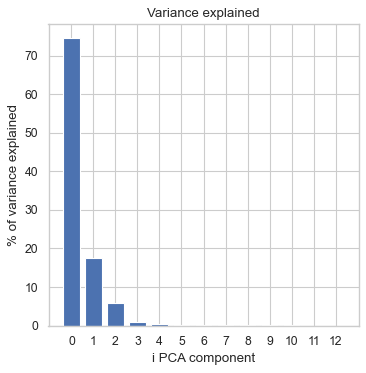

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax.bar(range(0,Nc),V*100)
ax.set_xlabel('i PCA component')
ax.set_ylabel('% of variance explained')
ax.grid(True)
ax.set_xticks(range(0,Nc))
ax.set_title('Variance explained')
plt.show()

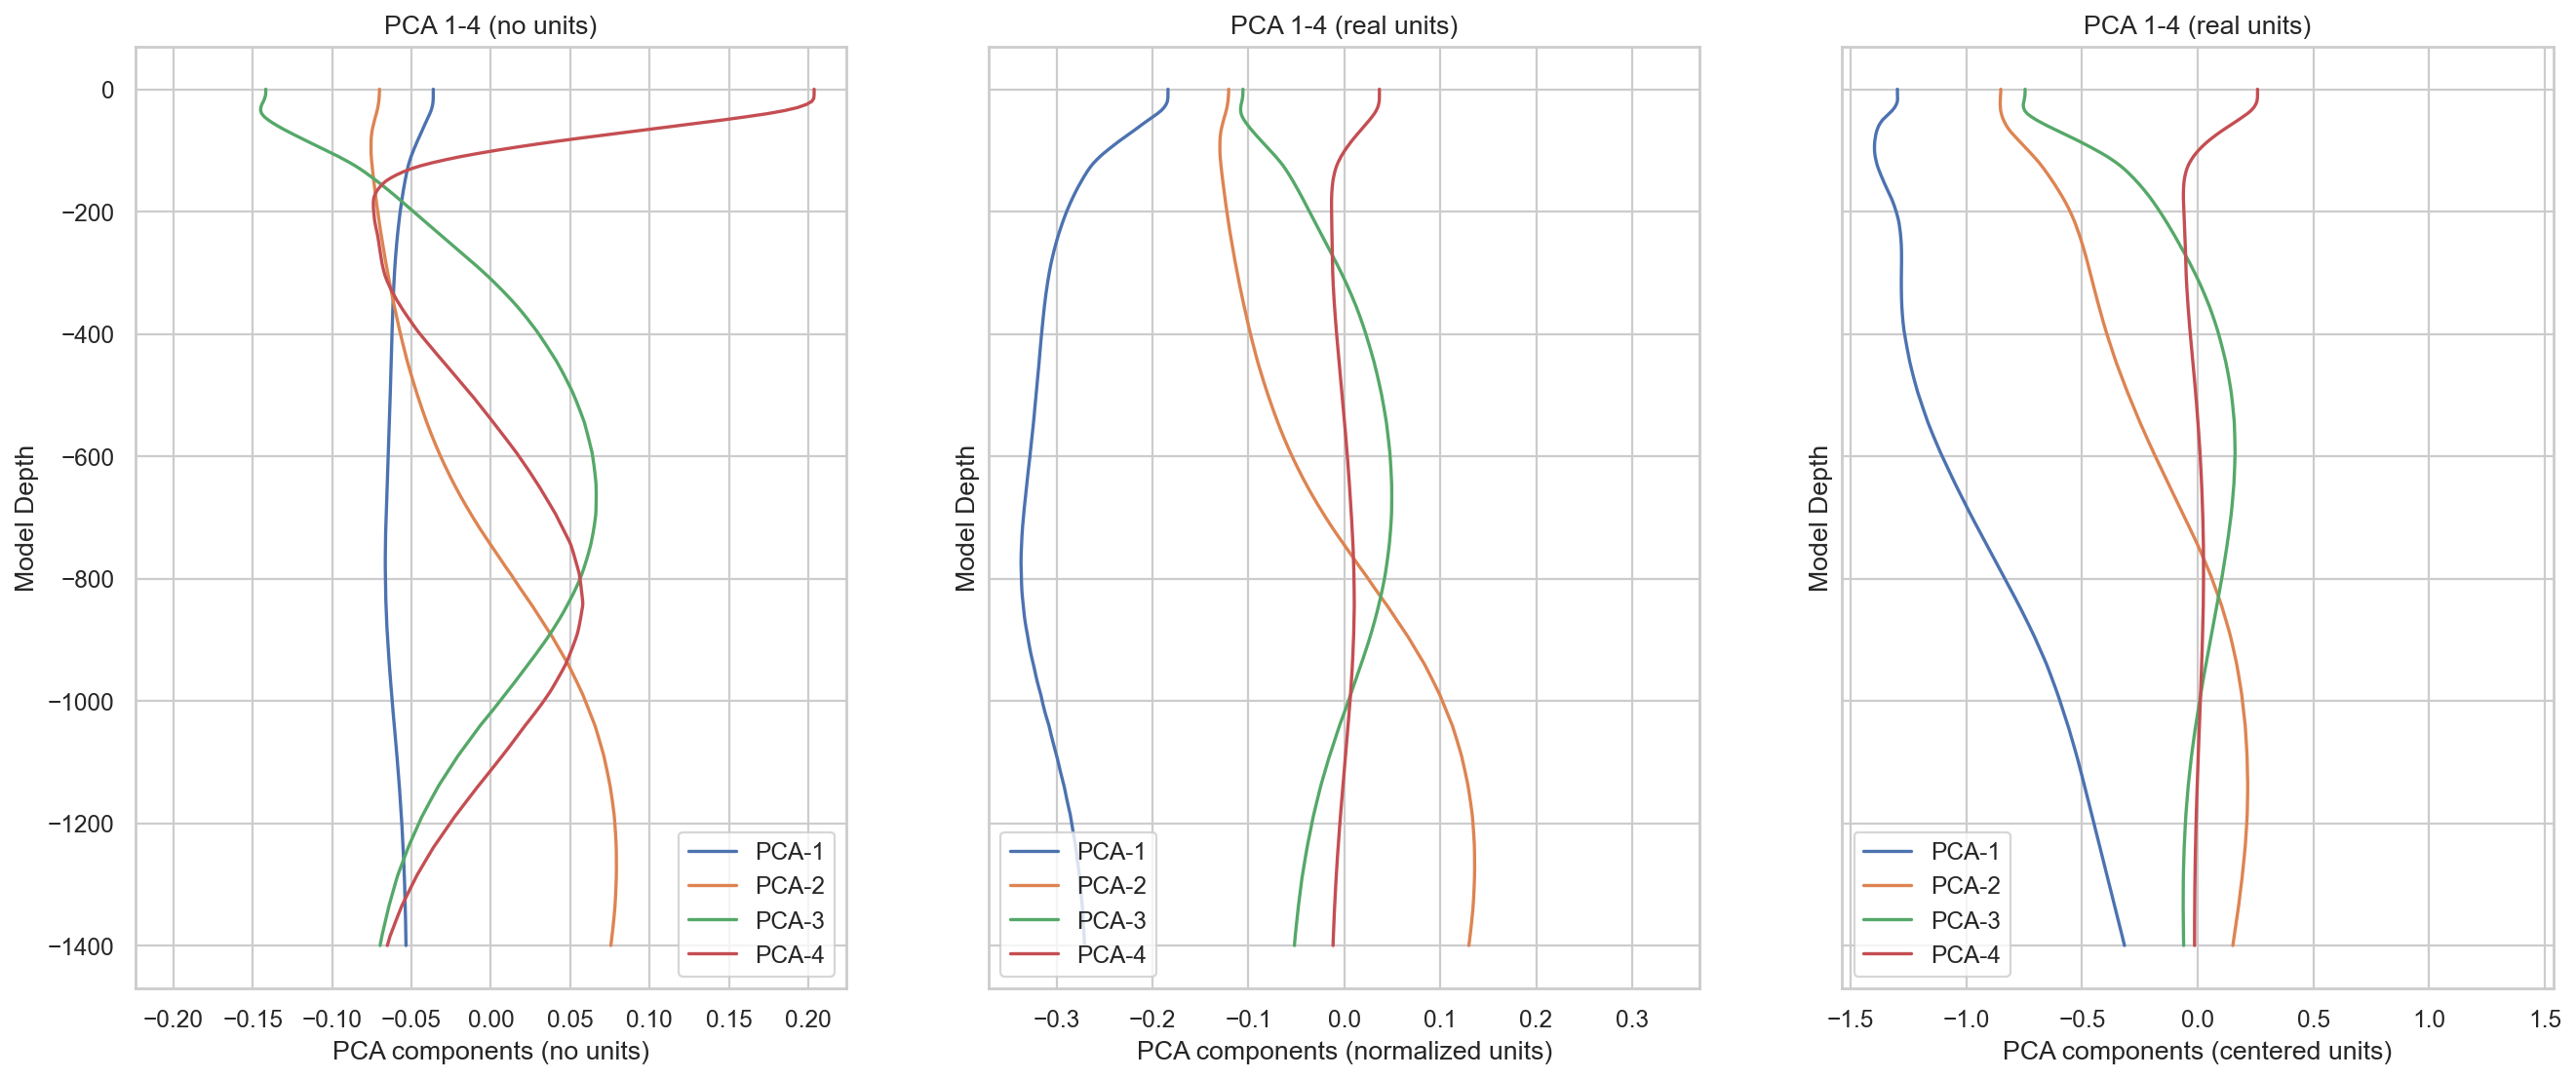

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8), dpi=160, facecolor='w', edgecolor='k', sharey='row')

iax = 0
xl = np.max(np.abs([np.min(EOFs),np.max(EOFs)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower right')
ax[iax].set_xlabel('PCA components (no units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (no units)')

iax+=1
xl = np.max(np.abs([np.min(EOFs_real),np.max(EOFs_real)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs_real[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower left')
ax[iax].set_xlabel('PCA components (normalized units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (real units)')

iax+=1
xl = np.max(np.abs([np.min(EOFs_realc),np.max(EOFs_realc)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs_realc[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower left')
ax[iax].set_xlabel('PCA components (centered units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (real units)')
plt.show()

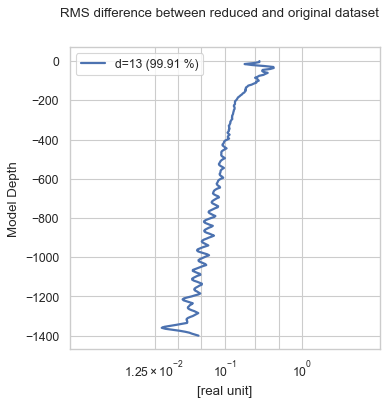

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax.semilogx(rms, DPTmodel, '-', linewidth=2,label="d=%i (%0.2f %%)"%(Nc,np.sum(V*100)))
# tidy up the figure
ax.legend(loc='upper left')
ax.set_xticks([0.0125,0.025,0.05,0.1,0.25,0.5,1])
ax.set_xlim([1e-3,1e1])
ax.set_xlabel('[real unit]')
ax.set_ylabel('Model Depth')
ax.grid(True)
fig.suptitle('RMS difference between reduced and original dataset', fontsize=12)
plt.show()

## GMM Classification
We classify with a GMM the reduce dataset

Doc: http://scikit-learn.org/stable/modules/mixture.html

In [15]:
%%time
# Set-up and train the classifier:
gmm = GaussianMixture(n_components=K,\
                      covariance_type='full',\
                      init_params='kmeans',\
                      max_iter=1000,\
                      tol=1e-6)
gmm.fit(Xr) # Training on reduced data

# Extract GMM parameters:
priors = gmm.weights_ # [K,1]
centers= gmm.means_   # [K,Nc]
covars = gmm.covariances_ # [K,Nc,Nc] if 'full'

CPU times: user 39.4 s, sys: 1.3 s, total: 40.7 s
Wall time: 5.41 s


In [16]:
# Classify the dataset:
LABELS = gmm.predict(Xr) # [Np,1]
POST   = gmm.predict_proba(Xr) # [Np,Nc]

## Time for a lot of figures

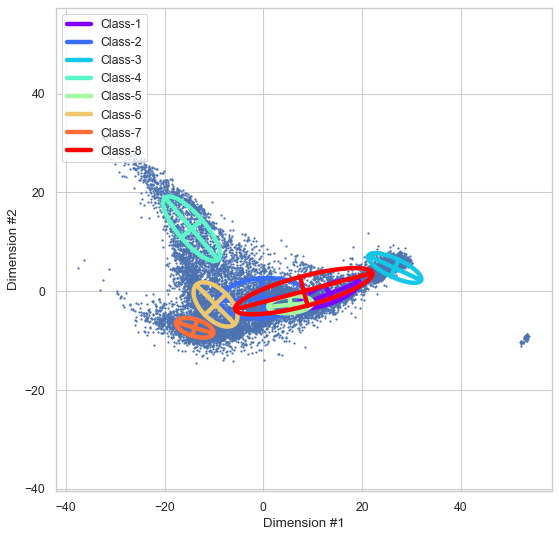

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(Xr[:,id[0]],Xr[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
colors = mpl.colors.cnames.items()
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
    el,ax = plot_GMMellipse(gmm, id, ik, next(colors), ax, label="Class-%i"%(ik+1), plot_kw={'linewidth':4})
#     el,ax = plot_GMMellipse(gmm, id, ik, next(colors), ax, label="Class-%i"%(ik+1))
#    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),std=[1],linewidth=4)
ax.legend(loc='upper left')
plt.show()

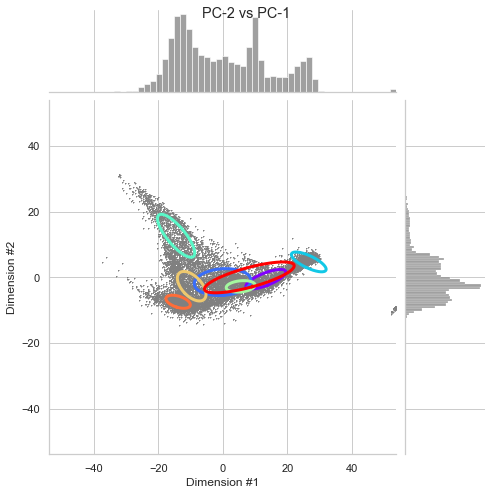

In [18]:
import pandas as pd
df = pd.DataFrame(Xr[:,id], columns=["x", "y"])
sns.set(context="notebook",style="whitegrid", color_codes=True)
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))

g = sns.JointGrid(x="x", y="y", data=df, height=7, ratio=4, space=0.1,
                  xlim=vrangec(Xr[:,id]),ylim=vrangec(Xr[:,id]))

g.plot_marginals(sns.histplot, kde=False, stat='density', color=".5")

g.plot_joint(plt.scatter, c=".5", s=1, linewidth=1, marker="+")

g.plot_joint(sns_GMMellipse, gmm=gmm, id=id, main_axes=False, colors=colors, linewidth=3)

g.set_axis_labels("Dimension #%i"%(id[0]+1), "Dimension #%i"%(id[1]+1))
g.fig.suptitle("PC-%i vs PC-%i"%(id[1]+1,id[0]+1))
plt.show()

/Users/gmaze/anaconda/envs/ds2/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(


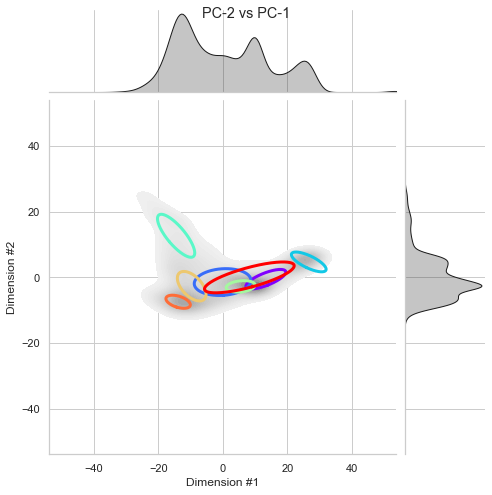

/Users/gmaze/anaconda/envs/ds2/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(


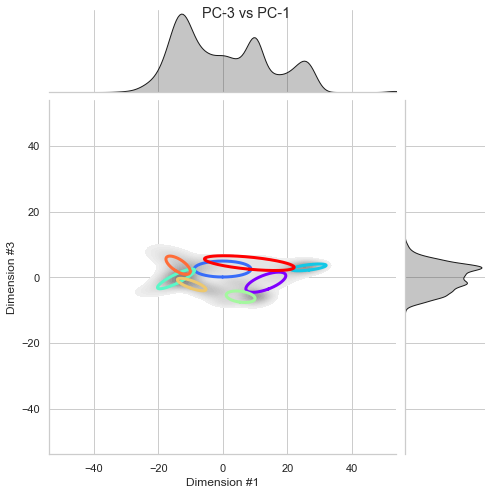

In [19]:

for ii in np.arange(2,4):
    id = np.array([1,ii])-1
    df = pd.DataFrame(Xr[:,id], columns=["x", "y"])
    sns.set(context="notebook", style="whitegrid", color_codes=True)
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
    
    g = sns.JointGrid(x="x", y="y", data=df, height=7, ratio=4, space=0.1,
                      xlim=vrangec(Xr[:,id]),ylim=vrangec(Xr[:,id]))
    #g.plot_joint(sns.kdeplot, cmap="Purples_d", kind='hex', linewidth=1, color='k', n_levels=30)
    #g.plot_joint(sns.kdeplot, shade = True, cmap="Purples_d", kind='hex', n_levels=30)
    g.plot_joint(sns.kdeplot, shade = True, \
                 thresh=0.05,\
                 cmap=sns.light_palette("gray",reverse=False,as_cmap=True), kind='hex', n_levels=30)
    #g.plot_joint(sns.kdeplot, shade = False, kind='hex', n_levels=10)
    g.plot_marginals(sns.kdeplot, color="k", shade=True)

    g.plot_joint(sns_GMMellipse, gmm=gmm, id=id, main_axes=False, colors=colors, linewidth=3)

    g.set_axis_labels("Dimension #%i"%(id[0]+1), "Dimension #%i"%(id[1]+1))
    g.fig.suptitle("PC-%i vs PC-%i"%(id[1]+1,id[0]+1))
    plt.show()

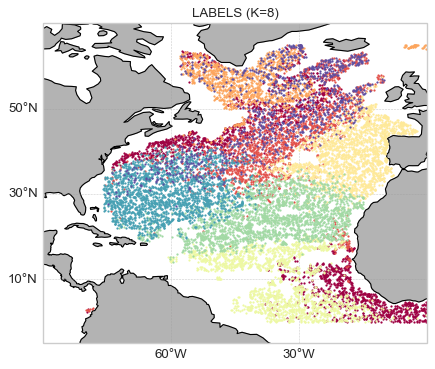

In [20]:
# Plot LABELS map:
unique_labels = set(LABELS)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, proj, ax = create_map(extent=[-90, 0, -5, 70], dpi=80)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
    class_member_mask = (LABELS == k)

    plt.plot(lon[class_member_mask],
                lat[class_member_mask],
                 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=2,  
             label="Class %i"%(k), transform=proj)

plt.title("LABELS (K=%i)"%(K))
# plt.legend()
plt.show()

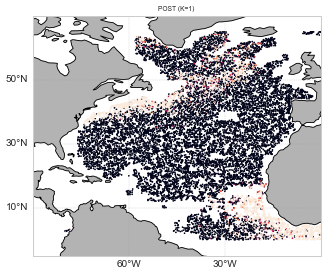

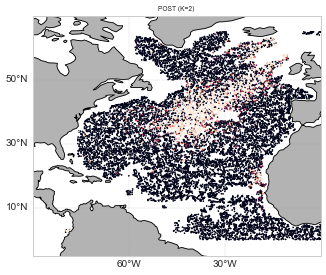

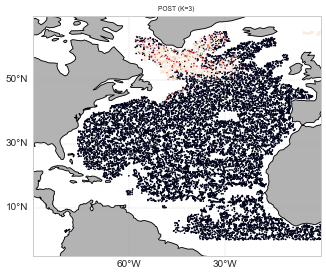

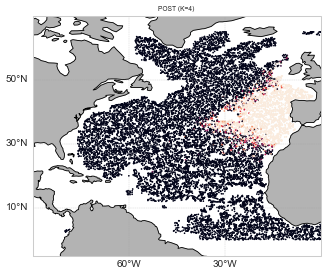

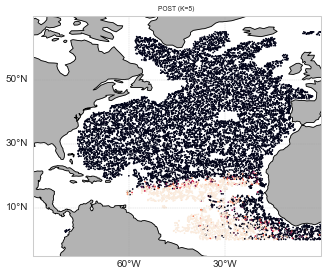

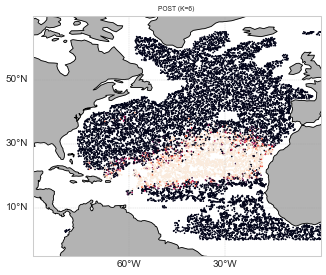

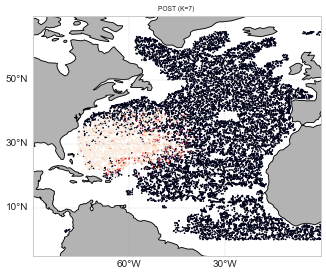

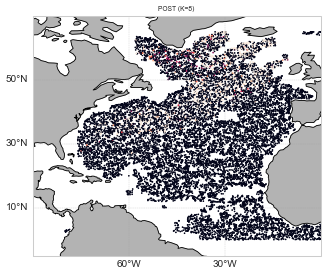

In [21]:
# Plot POSTERIORS map:
for k, col in zip(unique_labels, colors):
    fig, proj, ax = create_map(extent=[-90, 0, -5, 70], dpi=60)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
#     class_member_mask = (LABELS == k)

    plt.scatter(lon,lat,1,POST[:,k], transform=proj)

    plt.title("POST (K=%i)"%(k+1),fontsize=8)
plt.show()

# Exercise

Compute and plot the robustness of the classification